<a href="https://colab.research.google.com/github/wumouyan/Colaboratory-Notes/blob/master/bds3_b1c_acq_publish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beidou B1C

## Open file

Fetch recorded antenna data from file in Google Drive.


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1ISkC8N1KLaI8_eOJQCmZzek4mNqqdjsB'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data');

## Read file

Read the recorded antenna data file and do a very simple sanity check by plotting the I/Q values in a histogram. They should be balanced, because there can not be an offset in the received signal. This verifies the correct functionality of the signal sampling.

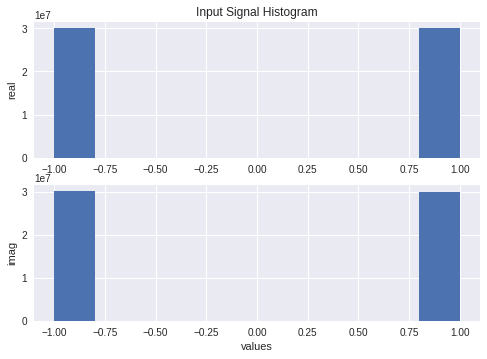

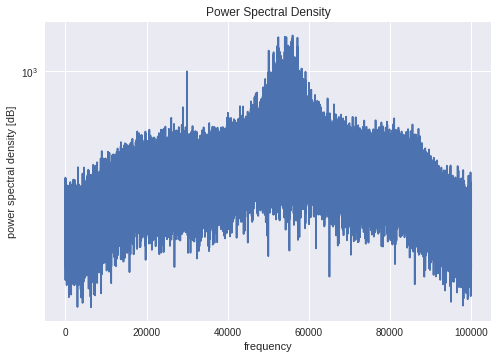

In [0]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt

# Parameters Signal 
FCHIP = 1.023e6
FCENTER = 1575.42e6
CODE_LEN = 10230
CODE_PERIOD = CODE_LEN / FCHIP

# Parameters File
FS = 10e6
FCENTER_REC = 1575e6
FIF = FCENTER - FCENTER_REC
INTERLEAVED = 1
SAMP_PER_MS = int(round(FS / 1000))

# Parameters Simulation
NUM_MS = 6000
NUM_SAMPLES = NUM_MS * SAMP_PER_MS
NUM_SAMPLE_SKIP = 30000+4660

x = np.fromfile('data', dtype='int8', 
                count=(INTERLEAVED+1)*(NUM_SAMPLES + NUM_SAMPLE_SKIP))
x = x[2*NUM_SAMPLE_SKIP:]

# Separate interleaved samples for I/Q
i = x[0::2]
q = x[1::2]

plt.subplot(2,1,1)
plt.title('Input Signal Histogram')
plt.hist(i)
plt.ylabel('real')
plt.subplot(2,1,2)
plt.hist(q)
plt.xlabel('values')
plt.ylabel('imag')
plt.show()

# Compute complex values
sig = i + 1j * q

# Split into chunks of single code periods
NUM_MS_IN_PERIOD = int(CODE_PERIOD / 0.001)
NUM_CODE_PERIODS = int(NUM_MS / NUM_MS_IN_PERIOD) 
sig = sig.reshape(NUM_CODE_PERIODS, SAMP_PER_MS * NUM_MS_IN_PERIOD)

# Average spectrum for 10 ms 
psd_avg = 0
for k in range(0,10):
  psd_avg += fft.fftshift(abs(fft.fft(sig[k,:])))
psd_avg /= 10.

plt.semilogy(psd_avg)
plt.title('Power Spectral Density')
plt.ylabel('power spectral density [dB]')
plt.xlabel('frequency')
plt.show()

## Generate Codes

Codes are generated according to the ICD. The code needs to be up-sampled to 10 Msps, to match the sampling rate FS of the incoming signal. 

In [0]:
WEIL_N = 10243

legendre = np.zeros(WEIL_N, dtype=int)
for k in range(1,WEIL_N):
  leg = 0
  for x in range(1,WEIL_N):
    if ((x**2) % WEIL_N) == k:
      leg = 1
      break
  legendre[k] = leg

In [0]:
w_table_data = [2678, 4802,  958,  859, 3843, 
                2232,  124, 4352, 1816, 1126,
                1860, 4800, 2267,  424, 4192,
                4333, 2656, 4148,  243, 1330,
                1593, 1470,  882, 3202, 5095,
                2546, 1733, 4795, 4577, 1627,
                3638, 2553, 3646, 1087, 1843]

p_table_data = [ 699,  694, 7318, 2127,  715,
                6682, 7850, 5495, 1162, 7682, 
                6792, 9973, 6596, 2092,   19,
               10151, 6297, 5766, 2359, 7136,
                1706, 2128, 6827,  693, 9729,
                1620, 6805,  534,  712, 1929,
                5355, 6139, 6339, 1470, 6867]

w_table_pilot = [ 796,  156, 4198, 3941, 1374, 
                 1338, 1833, 2521, 3175,  168,
                 2715, 4408, 3160, 2796,  459,
                 3594, 4813,  586, 1428, 2371,
                 2285, 3377, 4965, 3779, 4547,
                 1646, 1430,  607, 2118, 4709,
                 1149, 3283, 2473, 1006, 3670]

p_table_pilot = [7575, 2369, 5688,  539, 2270,
                 7306, 6457, 6254, 5644, 7119, 
                 1402, 5557, 5764, 1073, 7001,
                 5910,10060, 2710, 1546, 6887,
                 1883, 5613, 5062, 1038,10170,
                 6484, 1718, 2535, 1158,  526,
                 7331, 5844, 6423, 6968, 1280]

def b1ci(prn):        
  weil = legendre ^ np.roll(legendre, -w_table_data[prn-1])
  weil_rot = np.roll(weil, - (p_table_data[prn-1] - 1))
  output = weil_rot[0:10230]  
  return output

def b1cq(prn):        
  weil = legendre ^ np.roll(legendre, -w_table_pilot[prn-1])
  weil_rot = np.roll(weil, - (p_table_pilot[prn-1] - 1))
  output = weil_rot[0:10230]
  return output

# Generate codes
codes = [(1 - 2 * b1cq(prn)) for prn in range(1,35)]

# Resample codes and add BOC(1,1)
NUM_SAMPLES_PER_CODE_PERIOD = int(np.round(FS * CODE_PERIOD))
idx = np.arange(NUM_SAMPLES_PER_CODE_PERIOD)
np.floor(idx * 2 * FCHIP / FS, out=idx, casting='unsafe')

resamp_codes = []
for code in codes:
  tmp = np.repeat(code,2)
  tmp[1::2] = -tmp[1::2]
  resamp_codes.append(tmp[idx])

## Acquisition

This is done through a parallel acquisition approach, using FFT for the correlation. 

In [0]:
# Parameters
THRESHOLD = 2500
DOPP_MAX = 3000
DOPP_STEP = 60

t = np.linspace(0, CODE_PERIOD, num=NUM_SAMPLES_PER_CODE_PERIOD, endpoint=False)
candidates = []

for i, code in enumerate(resamp_codes):
  for freq in range (-DOPP_MAX, DOPP_MAX, DOPP_STEP):
    baseband = (sig[0,:] * np.exp(-2*np.pi*1j*t*(FIF+freq)))
    xcorr = abs(fft.ifft(fft.fft(baseband) * np.conj(fft.fft(code))))
    xcorr_max = max(xcorr)
    xcorr_max_idx = np.argmax(xcorr)
    if xcorr_max >= THRESHOLD:
      candidates.append((i+1, freq, xcorr_max_idx, xcorr_max))

# Print acquired satellites
print('prn\tdoppler \tsample_idx\tcorr value')
for c in candidates:
  print('%2d \t %5d \t\t %4d \t\t %5.2f' % (c[0],c[1],c[2],c[3]))


prn	doppler 	sample_idx	corr value
20 	  1740 		 81103 		 8433.01
20 	  1800 		 81103 		 7475.55
29 	     0 		 30006 		 7067.46
29 	    60 		 30006 		 12408.87
29 	   120 		 30006 		 5381.02


## Tracking

Doppler recovery is done by looking at phase drift.

We choose to track satellite PRN 29, from looking at the acquisition results. 
It was acquired at a doppler of 60-120 Hz, so we kick off at 90 Hz.

In [0]:
# Parameter
SAT = 29
ALPHA_LP = 0.25
DOPP_FREQ_INIT = 90

dopp_freq = [DOPP_FREQ_INIT]
xcorr_max = {}
a_diff_vals = {}
trk_sample_idx = {}
phase_init = 0
bits = [1]

code = resamp_codes[SAT-1]

# Loop through code periods
for prd in range(NUM_CODE_PERIODS):

  # Modulate to baseband with current estimated doppler
  phase = 2*np.pi*(FIF+dopp_freq[-1])
  baseband = sig[prd,:] * np.exp(-1j*(phase_init + phase*t))
  phase_init = phase_init + phase * CODE_PERIOD

  # Cross-correlate and get complex maximum
  xcorr = fft.ifft(fft.fft(baseband) * np.conj(fft.fft(code)))
  xcorr_max_idx = np.argmax(abs(xcorr))
  xcorr_max[prd] = xcorr[xcorr_max_idx]
  trk_sample_idx[prd] = xcorr_max_idx

  # Calculate phase difference from last period
  if prd >= 1:
    a0 = np.angle(xcorr_max[prd-1]) / (2 * np.pi)
    a1 = np.angle(xcorr_max[prd]) / (2 * np.pi)
    a_diff = a1 - a0
    
    # Limit rotation to +/- 0.5 cycle
    if a_diff > +0.5:
      a_diff -= 1.0
    if a_diff < -0.5:
      a_diff += 1.0

    # Determine databit transition
    flip = 1
    if a_diff > +0.25:
      a_diff -= 0.5
      flip = -1
    elif a_diff < -0.25:
      a_diff += 0.5
      flip = -1
      
    bits.append(bits[-1] * flip)
      
    a_diff_vals[prd] = a_diff
    target_dopp_freq = dopp_freq[-1] + (a_diff / CODE_PERIOD)
    
    new_doppler = (1-ALPHA_LP)*dopp_freq[-1] + (ALPHA_LP)*(target_dopp_freq)
    dopp_freq.append(new_doppler)
    

## Tracking Results

Initial Doppler:  90.00 Hz
Tracked Doppler:  101.45 Hz


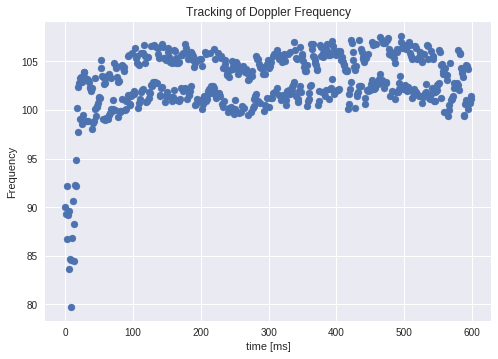

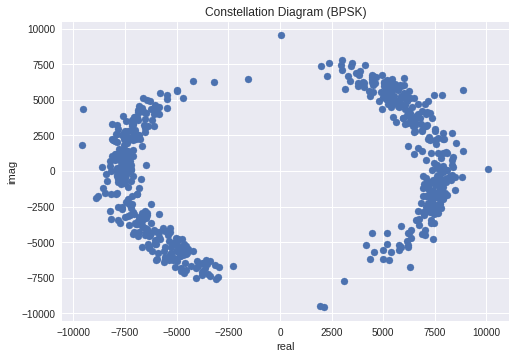

In [0]:
print('Initial Doppler:  %.2f Hz' % DOPP_FREQ_INIT)
print('Tracked Doppler:  %.2f Hz' % dopp_freq[-1])

plt.figure()  
plt.title('Tracking of Doppler Frequency')
plt.ylabel('Frequency')
plt.xlabel('time [ms]')
plt.scatter(range(int(NUM_MS/10)),dopp_freq)
plt.show()

# Transform complex values to cartesian
x = [n.real for n in xcorr_max.values()]
y = [n.imag for n in xcorr_max.values()]

# Plots
plt.scatter(x, y)
plt.title('Constellation Diagram (BPSK)')
plt.ylabel('imag')
plt.xlabel('real')
plt.show()

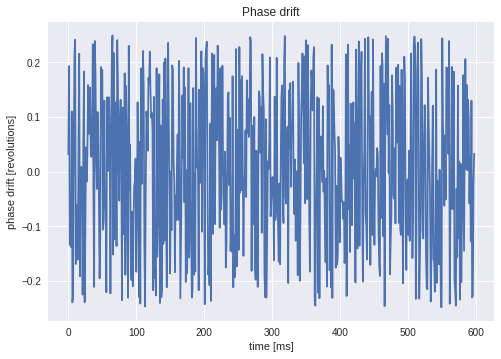

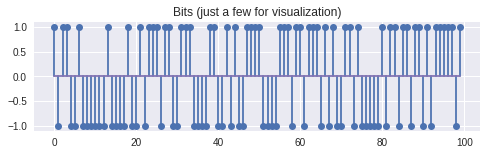

In [0]:
plt.figure()
plt.title('Phase drift')
plt.ylabel('phase drift [revolutions]')
plt.xlabel('time [ms]')
plt.plot(a_diff_vals.values())
plt.show()

plt.figure(figsize=(8,2))
plt.title('Bits (just a few for visualization)')
plt.stem(bits[:100])
plt.show()

Those are the data bits received, without stripping of the secondary code. According to the ICD, there is a secondary code on the pilot, which is 1800 chips long. A secondary code chip overlays an entire primary code period. A primary code period is 10 ms long (100 chip/s), so this would be 18 seconds. We would have to process at least the length of one whole secondary code to verify that.

## Conclusion

We could show the complete chain of signal processing from raw antenna data to data bits.

In order to demodulate the data bits to actual navigation data bit information, further processing, such as stripping the secondary codes would be required.

Due to time limitations we did not continue here.